# Business Problem (Product Launch)

Situation: A product manager proposed a new feature called "order bump" (see image below) to encourage customers to add more items to their cart before completing check out. The feature aimed at improving revenue in product sales by encouraging additional purchases during the checkout process. 

Task: As the data scientist, I was looking to design an experiment with A/B testing and interpret the results to see if this was a good idea by separating two groups of customers where customers in the treatment group were exposured to the new feature and the control group were not.

<img src="https://orderbump.io/images/og-order-bump.jpg" width="450">



This script mainly focused on how I interpreted the experiment results by analyzing the data and applying statistical techniques in order to make a recommendation on launching the new features.

1. Exploratory Data Analysis and Sanity Check (outliers, random assignments, pre-test differences between variants)

2. Developing Hypothesis Testing

3. Making a Launch Decision

## Results Interpretation

Starting with importing the libraries for analysis and importing the experiment data.

In [1]:
# handle data
import pandas as pd
import numpy as np

# visualize data
import seaborn as sns
import matplotlib.pyplot as plt

# run tests with statistical methods
from scipy import stats
import statsmodels.stats.api as sms

# aesthetics
sns.set(font_scale=2) # set font size of the charts 
pd.options.mode.chained_assignment = None # no warning message and no exception is raised

In [2]:
# load all the data
df_pre = pd.read_csv("transactions_pre.csv")
df_post = pd.read_csv("transactions_post.csv")
df_meta = pd.read_csv("assignment.csv")

Additional information about the three data files:

1. Transaction data before the experiment: `transactions_pre.csv`

 - `customer_id` (data type: integer): unique identifier of each customer
 - `transaction_date` (data type: datetime): the date on which the transaction happened
 - `amount_usd` (data type: float): the US dollar amount paid by the customer in the transaction
     
2. Transaction data after the experiment: `transactions_post.csv` (same structure as the pre-test data)
     
3. Metadata on experiment assignments: `assignment.csv`
 - `customer_id` (data type: integer): unique identifier of each customer
 - `variant` (data type: string): whether the customer was assigned to the experiment or the control variant


In [3]:
df_pre.head()

,customer_id,transaction_date,amount_usd
0,3,2020-02-11,41.09
1,3,2020-02-14,16.64
2,3,2020-02-15,13.49
3,3,2020-02-21,1.04
4,3,2020-02-28,0.96


In [4]:
df_post.head()

,customer_id,transaction_date,amount_usd
0,3,2020-09-01,7.25
1,3,2020-09-08,9.81
2,3,2020-09-16,2.07
3,3,2020-09-22,4.69
4,3,2020-09-27,2.08


In [5]:
df_meta.head()

,customer_id,variant
0,3,control
1,4,control
2,6,control
3,14,control
4,18,control


### Exploratory Data Analysis and Sanity Check 
To perform successful experiments, I needed to ensure that the data distributions passed sanity checking without violating the test assumptions by considering 
 - outliers
 - random assignments
 - pre-test differences between variants

#### 1. Outliers
Let's begin by checking for outliers and anomalies in the transaction data.

In [6]:
# pre-treatment summary statistics
df_pre["amount_usd"].describe()

count    443748.000000
mean         24.962695
std         950.452061
min           0.900000
25%           1.990000
50%           4.170000
75%          12.800000
max      109313.450000
Name: amount_usd, dtype: float64

#### Histogram of Transaction Amount Before Experiment

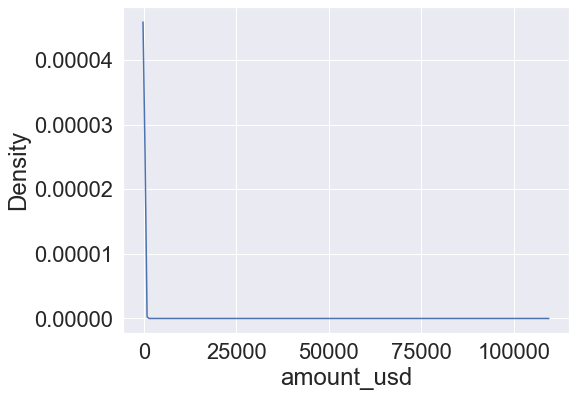

In [7]:
# plot the distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_pre, x="amount_usd")
plt.show()

In [8]:
# post-treatment summary statistics
df_post["amount_usd"].describe()

count    398013.000000
mean         37.246828
std        1271.811492
min           0.900000
25%           2.130000
50%           5.550000
75%          17.310000
max      109954.310000
Name: amount_usd, dtype: float64

#### Histogram of Transaction Amount After Experiment

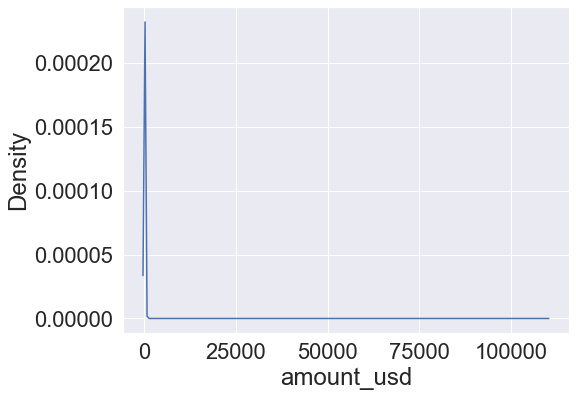

In [9]:
# plot the distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_post, x="amount_usd")
plt.show()

The vertical axis (probability density function) of the histogram indicates the relative likelihood that the value of the transaction amount would be close to that sample. Both charts showed that a large number of customers were in the low range and only a few customers were in the high range (the long tail) who contributed a disproportionately large amount to the total revenue, which may violate the assumptions and mess up the hypothesis testing. 

Solutions for outliers: first log transform `amount_usd` and then remove transactions whose values are outside of the 99th percentile.

There's something tricky though: percentiles are relative, so we may want to look at transaction data in both periods to establish a common standard for what counts as outliers.

In [10]:
# find the cutoff for what counts as outliers

# merge the two transactions datasets before and after the experiement into a single table
df_both = pd.concat([df_pre, df_post]) 

# log-transform transaction amount from all data in both periods
df_both["log_amount_usd"] = df_both["amount_usd"].apply(lambda x: np.log(x))

# find the cutoff for what counts as outliers in both periods
cutoff = df_both["log_amount_usd"].quantile(0.99)

In [11]:
def remove_outliers(df, cutoff):
    # log-transform transaction amount
    df["log_amount_usd"] = df["amount_usd"].apply(lambda x: np.log(x))

    # create a new dataframe without outliers
    df_new = df[df["log_amount_usd"] <= cutoff]

    # return new dataframe
    return df_new

In [12]:
# remove outliers in both pre- and post-test data
df_pre_clean = remove_outliers(df_pre, cutoff)
df_post_clean = remove_outliers(df_post, cutoff)

Now we can aggregate the data and calculate average revenue per user, which served as the primary metric to evaluate changes by the feature.

In [13]:
def aggregate_by_customer(df):

    # get average transaction amount or revenue for each customer
    revenue = df.groupby("customer_id").mean().reset_index()

    # only select columns we need: customer_id and average revenue
    revenue = revenue[["customer_id", "amount_usd"]]
    revenue.rename(columns={"amount_usd": "avg_revenue"}, inplace=True)

    # return new dataframe
    return revenue

In [14]:
# aggregrate in each period
agg_pre = aggregate_by_customer(df_pre_clean)
agg_post = aggregate_by_customer(df_post_clean)

#### 2. Random assignments

If assignment is random, there should be the same number of units in each variant through out the experiment. To see if this is the case, we need to join the data first. I think LEFT JOIN is most appropriate: If someone bought something before the experiment began but didn't make any transactions afterwards, it could indicate a lost interest. If we use INNER JOIN, we lose such information.

In [15]:
# LEFT JOIN data in each period
df = agg_pre.merge(agg_post, on="customer_id", how="left", suffixes=["_pre", "_post"])
df.fillna(0, inplace=True)  # if no transaction happened, treat the amount as 0

# find the variant of each customer by identifying which group the customer belonged to
df = df.merge(df_meta, on="customer_id")

In [16]:
# how many units are in each variant?
df.groupby("variant").size()

variant
control      9941
treatment    9921
dtype: int64

The number is really close. The assignment between control and treatment groups looks random!

#### 3. Pre-test differences

In [17]:
# isolate pre-test data
treatment_pre = df[df["variant"] == "treatment"]["avg_revenue_pre"]
control_pre = df[df["variant"] == "control"]["avg_revenue_pre"]

The t-test quantifies the difference between the arithmetic means of the two samples. The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. 

If the p-value is smaller than the threshold (e.g. 5% or 1%), then we have evidence against the null hypothesis of equal population means.

In [18]:
# test for difference in treatment vs. control means
stats.ttest_ind(treatment_pre, control_pre)

Ttest_indResult(statistic=-7.197679548774967, pvalue=6.342861266582803e-13)

Too bad, the average revenue per customer is already different in the pre-test period! This is a strong indicator that customers are not randomly assigned to each variant.

When the variants were already different before the experiment, it does not work to compare the metric values in the post-test data. 

But one solution is to compute the post- vs. pre-test change in each customer's average revenue. If the treatment has an effect on customers' behavior, then the average change should be different in each variant.

In [19]:
# compute change in average revenue per customer
df["avg_rev_delta"] = df["avg_revenue_post"] - df["avg_revenue_pre"]

In [20]:
# isolate data for comparison
treatment = df[df["variant"] == "treatment"]["avg_rev_delta"]
control = df[df["variant"] == "control"]["avg_rev_delta"]

### Applying Hypothesis Testing

We can use a two-sample t-test to understand whether the feature had an impact on the change in average revenue per customer. Below are some basic assumptions behind t-test:

- **Independence** between and within groups
- **Normality** in each group
- To pool variance, each group should have **equal variance**

We have no evidence for or again whether the customers are dependent somehow (e.g., in the same household), which is common for online experiments, so don't fret too much about this. After testing for normality (detailed below), I found that the metric is normally distributed in both variant and since we have a large sample, it's likely that the sampling distribution is still normal (central limit theorem). As for the last assumption, pooling variance or not usually doesn't make a huge difference.

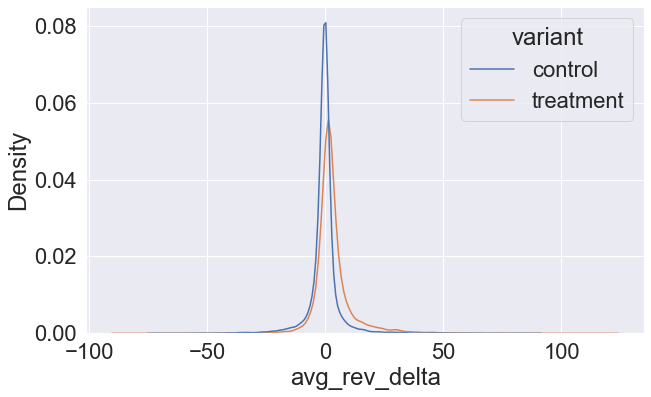

In [22]:
# plot the distributions to check for normality in each group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="avg_rev_delta", hue="variant")
plt.show()

In [23]:
# test for difference in treatment vs. control changes
stats.ttest_ind(treatment, control)

Ttest_indResult(statistic=31.208213551875527, pvalue=8.888175777344926e-209)

For treatment, the average revenue per customer increased much more than it did for control.

In [24]:
# let's get 95% CI
sms.CompareMeans(sms.DescrStatsW(treatment), sms.DescrStatsW(control)).tconfint_diff(
    usevar="unequal"
)

(3.200232388660616, 3.6292705515721653)

This is confirmed by 95% CI: The lower bound is greater than 0.

## Make a Launch Decision

I advocated for the launch of the feature because:
1. Compared to control, the treatment improved significantly more in terms of average revenue per customer
2. Average revenue per customer is absolutely key to the survival of my company and we urgently need need to improve it


Limitation:
In this case, something seems wrong with randomization such that the average revenue per customer was different between variants. so I asked the engineers to check the implementations. Otherwise, after we launch order bump, the same error may haunt other customers.

## Summary of Packages and Functions Used

1. Data Manipulation using Pandas and Numpy
 - describe() function to get the summary statistics including mean and standard deveation
 - concat() function to merge two datasets into a single dataset
 - apply (lambda) function to apply a function along an axis of the DataFrame
 - groupby() function to split the data into groups and apply certain aggregation
 - rename() function to change the column name
 - merge() function to join data from two tables
 - fillna() function to fill in missing values
 - size() function to count the number of rows
 - quantile() function to compute quantiles for a weighted sample
 
 
2. Data Visualization using Seaborn and Matplotlib
 - kdeplot() function to plot histogram
 - figure() function to edit the chart setting such as the size of the graph
 
 
3. Statistical Analysis using Statsmodels
 - ttest_ind() to perform an independent t-test to evaluate the statistical significance of the difference in the means 
 - normaltest() to conduct normality test to check for violation of assumptions for t-test
 - tconfint_diff() to return confidence interval for the difference in means
 - CompareMeans() to compare the means of two sample